In [ ]:
!pip install mpnum

     |████████████████████████████████| 78 kB 3.3 MB/s 


In [ ]:
import numpy as np
import scipy as sp
import functools as ft
import numpy.linalg as la
from scipy.sparse import lil_matrix, kron, identity, csr_matrix, random
from scipy.sparse.linalg import eigsh, norm, svds
from scipy.stats import unitary_group
import mpnum
import time
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from decimal import Decimal

### Addition of States

9.01726989648089 9.014124173436631 9.117984247915956


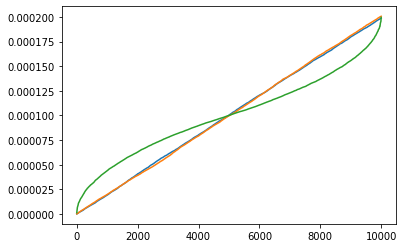

In [ ]:
def Entropy(p):
  return -np.sum(p*np.log(p))

n=10000
p1=np.random.rand(n)
p2=np.random.rand(n)

p1=p1/np.sum(p1)
p2=p2/np.sum(p2)
p12=p1+p2 #(np.sqrt(p1)+np.sqrt(p2))**2
p12=p12/np.sum(p12)

p1=np.sort(p1)
p2=np.sort(p2)

plt.plot(p1)
plt.plot(p2)
plt.plot(np.sort(p12))

print(Entropy(p1),Entropy(p2),Entropy(p12))

In [ ]:
N=64
d=2
max_rank=256

### SVD

In [ ]:
def Entangle(mpa,method='mps'):
  N=len(mpa)
  rank=max(mpa.ranks)

  if method=='full':
    #Warning: Full method can lead to memory run-offs. 
    psi=mpa.to_array()

  else:
    mpa.canonicalize(left=N//2-1, right=N//2)
    #print(mpa.canonical_form)

    M=mpa.lt
    psi=np.tensordot(M[N//2-1],M[N//2],axes=(-1,0))
  
  psi_shape=int(np.sqrt(psi.size))
  psi=np.reshape(psi,(psi_shape,psi_shape))
  
  S=la.svd(psi,compute_uv=False)
  #print(la.norm(S))
  S=S/la.norm(S)

  S2=np.abs(S)
  EE=-np.sum(S2**2*np.log2(S2**2+1e-32)) #Add eps=1e-32 to avoid log(0) error.
  return EE, S

In [ ]:
rank1=10
rank2=10
N=64
d=2

EE_hist=[]
EE1_hist=[]
EE2_hist=[]

for i in range(10):
  mpa1 = mpnum.random_mps(sites=N, ldim=d, rank=rank1)
  mpa2 = mpnum.random_mps(sites=N, ldim=d, rank=rank2)

  mpa= mpnum.sumup([mpa1,mpa2])
  mpa=mpa/mpnum.norm(mpa)

  EE,S=Entangle(mpa)
  EE_hist.append(EE)
  EE1,S1=Entangle(mpa1)
  EE1_hist.append(EE1)
  EE2,S2=Entangle(mpa2)
  EE2_hist.append(EE2)

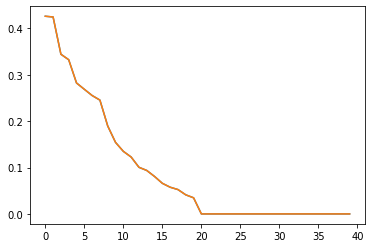

In [ ]:
#plt.plot(S1)
#plt.plot(S2)
plt.plot(S)
alpha = np.flip(np.sort(np.append(S1,S2)))/np.sqrt(2)
plt.plot(alpha)

$$S_T \leq \frac{(S_A + S_B)}{2} + log_2(2)$$

$$S_T \leq [aS_A + (1-a)S_B] + alog_2(a) + (1-a)log_2(1-a)$$


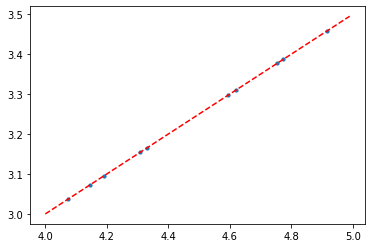

array([0.5, 1. ])

In [ ]:
EE1_hist=np.array(EE1_hist)
EE2_hist=np.array(EE2_hist)

plt.scatter(EE1_hist+EE2_hist,EE_hist,s=10)
x0=np.arange(4,5,0.01)
plt.plot(x0,x0/2+1,'r--')
plt.show()

x=EE1_hist+EE2_hist
y=EE_hist

np.polyfit(x,y,1)

### AGSP

In [ ]:
def AGSP():
  def loc_op():
    U = unitary_group.rvs(4)
    D=np.diag([1,1,0,0])
    A = U@D@U.T.conj()

    A=A.reshape((2,2,2,2))

    return mpnum.MPArray.from_array_global(A,ndims=2)

  DL_even = mpnum.factory.eye(sites=1, ldim=d)
  DL_odd = loc_op()

  for i in range(N//2-1):
    DL_odd = mpnum.chain([DL_odd, loc_op()])
    DL_even = mpnum.chain([DL_even, loc_op()])

  DL_even=mpnum.chain([DL_even, mpnum.factory.eye(sites=1, ldim=d)])

  A = mpnum.dot(DL_odd, DL_even)

  EE,S=Entangle(A,method='mpo')

  #print('square of singular values:', (S[:4]**2).round(3))

  return A

In [ ]:
rank1=10
rank2=10
N=16
S1_hist=[]
S2_hist=[]
SO_hist=[]
norm_hist=[]

for i in range(100):
  mpa = mpnum.random_mps(sites=N, ldim=d, rank=rank1)
  EE1,S1=Entangle(mpa)
  S1_hist.append(EE1)

  mpo = AGSP()
  EE,S=Entangle(mpo)
  SO_hist.append(EE)

  mpa = mpnum.dot(mpo,mpa)
  norm=mpnum.norm(mpa)

  norm_hist.append(norm)
  EE2,S2=Entangle(mpa)
  S2_hist.append(EE2)

square of singular values: [0.691 0.287 0.015 0.006]
square of singular values: [0.817 0.147 0.03  0.005]
square of singular values: [0.553 0.444 0.002 0.002]
square of singular values: [0.829 0.149 0.019 0.003]
square of singular values: [0.838 0.137 0.022 0.004]
square of singular values: [0.865 0.112 0.02  0.003]
square of singular values: [0.603 0.388 0.005 0.004]
square of singular values: [0.758 0.231 0.008 0.002]
square of singular values: [0.658 0.333 0.006 0.003]
square of singular values: [0.825 0.173 0.002 0.   ]
square of singular values: [0.659 0.335 0.004 0.002]
square of singular values: [0.605 0.395 0.    0.   ]
square of singular values: [0.761 0.204 0.028 0.008]
square of singular values: [0.858 0.105 0.033 0.004]
square of singular values: [0.832 0.143 0.021 0.004]
square of singular values: [0.837 0.114 0.043 0.006]
square of singular values: [0.702 0.247 0.037 0.013]
square of singular values: [0.76  0.231 0.007 0.002]
square of singular values: [0.743 0.254 0.003 

In [ ]:
SO_hist=np.array(SO_hist)
S1_hist=np.array(S1_hist)
S2_hist=np.array(S2_hist)
norm_hist=np.array(norm_hist)

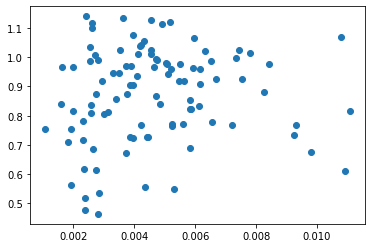

In [ ]:
plt.scatter(norm_hist,SO_hist)

### Operation

In [ ]:
def run_test(curr_iter, n_iter=8):
  rng = np.random.RandomState(seed=42)
  rank=1
  mpa = mpnum.random_mps(sites=N, ldim=d, rank=rank, randstate=rng)

  A=AGSP()
  #save(A, 'AGSP'+str(curr_iter))

  S_hist=np.zeros((d*max_rank,0))
  EE_hist=[]
  norm_hist=[]

  for i in range(n_iter):
    tm=time.time()

    mpa = mpnum.dot(A,mpa)
    norm=mpnum.norm(mpa)
    mpa=mpa/norm

    EE,S=Entangle(mpa)
    EE_hist.append(EE)
    S_exp=np.zeros(d*max_rank)
    S_exp[:len(S)]=S[:d*max_rank]
    S_hist=np.concatenate((S_hist, S_exp.reshape(-1,1)), axis=1)

    new_rank = np.count_nonzero(S_hist[:,i]>1e-16, axis=0)

    mpa.compress(method='var',
                      rank=min(new_rank, max_rank),
                      num_sweeps=4)
    
    norm_hist.append(norm)
    print("Epoch: ",i+1,"\t Rank: ", new_rank, "\t Entropy: ", '%.3E' % Decimal(EE), "\t Norm: ", '%.2E' % Decimal(norm), "\t Time: ",np.round(time.time()-tm,3))

  return S_hist, np.array(EE_hist), np.array(norm_hist)

In [ ]:
for i in range(1):
  S, EE, norm = run_test(i, n_iter=10)

  #save(S, 'S'+str(i))
  #save(EE, 'EE'+str(i))
  #save(norm, 'norm'+str(i))

square of singular values: [0.756 0.203 0.032 0.009]
Epoch:  1 	 Rank:  2 	 Entropy:  3.612E-01 	 Norm:  2.37E-12 	 Time:  0.436
Epoch:  2 	 Rank:  4 	 Entropy:  4.840E-01 	 Norm:  8.17E-07 	 Time:  0.465
Epoch:  3 	 Rank:  8 	 Entropy:  5.882E-01 	 Norm:  9.27E-06 	 Time:  0.527
Epoch:  4 	 Rank:  17 	 Entropy:  5.703E-01 	 Norm:  2.27E-05 	 Time:  1.496
Epoch:  5 	 Rank:  35 	 Entropy:  4.641E-01 	 Norm:  3.59E-05 	 Time:  3.355
Epoch:  6 	 Rank:  62 	 Entropy:  3.442E-01 	 Norm:  4.86E-05 	 Time:  9.869
Epoch:  7 	 Rank:  71 	 Entropy:  2.471E-01 	 Norm:  5.93E-05 	 Time:  21.956
Epoch:  8 	 Rank:  72 	 Entropy:  1.783E-01 	 Norm:  6.71E-05 	 Time:  26.939
Epoch:  9 	 Rank:  72 	 Entropy:  1.327E-01 	 Norm:  7.25E-05 	 Time:  27.685
Epoch:  10 	 Rank:  71 	 Entropy:  1.031E-01 	 Norm:  7.61E-05 	 Time:  27.677


### Plots

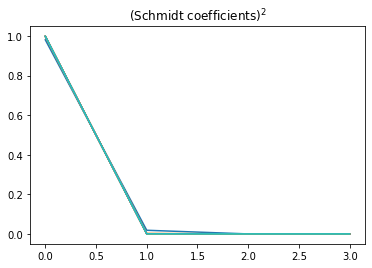

In [ ]:
plt.title('(Schmidt coefficients)$^2$')
plt.plot(np.arange(4),S[:4,:10]**2)
plt.show()

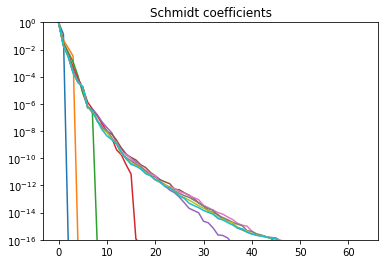

In [ ]:
plt.semilogy(S[:max_rank//4,:10])
plt.title('Schmidt coefficients')
plt.ylim((1e-16,1))
#plt.legend(np.arange(6,12))
plt.show()

In [ ]:
ER=np.count_nonzero(S>1e-16, axis=0)

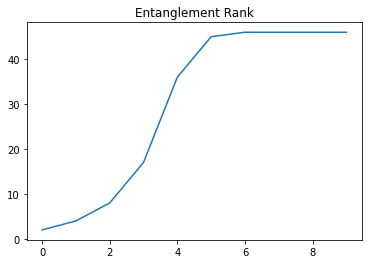

In [ ]:
plt.plot(ER)
plt.title('Entanglement Rank')
plt.show()

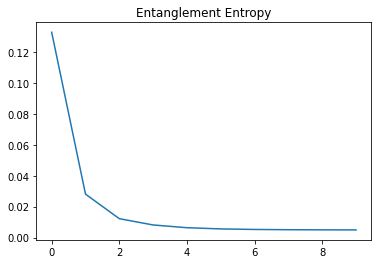

In [ ]:
plt.plot(EE)
#plt.plot(np.log2(ER[i].T))
plt.title('Entanglement Entropy')
#plt.hlines(EE,0,len(EE_hist)-1,colors='r',linestyles='dashed')
plt.show()

In [ ]:
log_norm=np.log2(norm)
norm_sum = np.cumsum(log_norm)

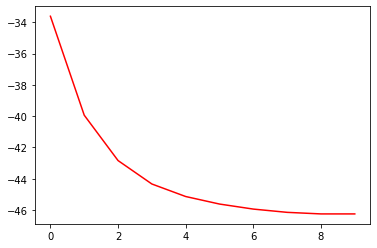

In [ ]:
plt.plot((norm_sum[:10] - np.outer(log_norm[9],np.arange(10))).T, c='r')
plt.show()

Let a_i be the norm cut down at the ith step.  Then we want to plot $f(k)= \prod_{i=1}^k a_i / (a_{10})^k$
